In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
import pickle

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis
import readdy_learn.analyze.cross_validation as cross_validation
from pathos.multiprocessing import Pool

import pynumtools.kmc as kmc

mpl.rcParams['figure.figsize'] = (16, 13)
import matplotlib.pyplot as plt
import scipy.signal as ss
from readdy_learn.example.regulation_network import RegulationNetwork
from readdy_learn.example.regulation_network import sample_lsq_rates
from readdy_learn.example.regulation_network import sample_along_alpha
from readdy_learn.example.regulation_network import DEFAULT_DESIRED_RATES

/home/mho/miniconda3/envs/readdy_learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_bfc_custom():
    # species DA  MA  A  DB  MB  B  DC  MC  C
    # ids     0   1   2  3   4   5  6   7   8
    bfc = basis.BasisFunctionConfiguration(9)
    # usual stuff A
    bfc.add_fission(0, 0, 1)  # 0   DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 2)  # 1   MA -> MA + A, translation A
    bfc.add_decay(1)  # 2   MA -> 0, decay
    bfc.add_decay(2)  # 3   A -> 0, decay
    # usual stuff B
    bfc.add_fission(3, 3, 4)  # 4   DB -> DB + MB, transcription B
    bfc.add_fission(4, 4, 5)  # 5   MB -> MB + B, translation B
    bfc.add_decay(4)  # 6   MB -> 0, decay
    bfc.add_decay(5)  # 7   B -> 0, decay
    # usual stuff C
    bfc.add_fission(6, 6, 7)  # 8   DC -> DC + MC, transcription C
    bfc.add_fission(7, 7, 8)  # 9   MC -> MC + C, translation C
    bfc.add_decay(7)  # 10  MC -> 0, decay
    bfc.add_decay(8)  # 11  C -> 0, decay

    # all possible regulations
    # self regulation
    bfc.add_fusion(1, 2, 2)  # 12  MA + A -> A, A regulates A
    bfc.add_fusion(4, 5, 5)  # 13  MB + B -> B, B regulates B
    bfc.add_fusion(7, 8, 8)  # 14  MC + C -> C, C regulates C
    # cyclic forward
    bfc.add_fusion(4, 2, 2)  # 15  MB + A -> A, A regulates B
    bfc.add_fusion(7, 5, 5)  # 16  MC + B -> B, B regulates C
    bfc.add_fusion(1, 8, 8)  # 17  MA + C -> C, C regulates A
    # cyclic backward
    bfc.add_fusion(7, 2, 2)  # 18  MC + A -> A, A regulates C
    bfc.add_fusion(4, 8, 8)  # 19  MB + C -> C, C regulates B
    bfc.add_fusion(1, 5, 5)  # 20  MA + B -> B, B regulates A

    # thrown these out due to being identical to decay
    # nonsense reactions, DNA eats mRNA self
    # bfc.add_fusion(1, 0, 0) # 21 MA + DA -> DA
    # bfc.add_fusion(4, 3, 3) # 22 MB + DB -> DB
    # bfc.add_fusion(7, 6, 6) # 23 MC + DC -> DC

    # nonsense reactions, DNA eats mRNA cyclic forward
    # bfc.add_fusion(4, 0, 0) # 24 MB + DA -> DA
    # bfc.add_fusion(7, 3, 3) # 25 MC + DB -> DB
    # bfc.add_fusion(1, 6, 6) # 26 MA + DC -> DC

    # nonsense reactions, DNA eats mRNA cyclic backward
    # bfc.add_fusion(7, 0, 0) # 27 MC + DA -> DA
    # bfc.add_fusion(4, 6, 6) # 28 MB + DC -> DC
    # bfc.add_fusion(1, 3, 3) # 29 MA + DB -> DB

    # nonsense reactions, mRNA eats protein self
    bfc.add_fusion(1, 2, 1)  # 21 MA + A -> MA
    bfc.add_fusion(4, 5, 4)  # 22 MB + B -> MB
    bfc.add_fusion(7, 8, 8)  # 23 MC + C -> MC

    # nonsense reactions, mRNA eats protein cyclic forward
    bfc.add_fusion(1, 5, 1)  # 24 MA + B -> MA
    bfc.add_fusion(4, 8, 4)  # 25 MB + C -> MB
    bfc.add_fusion(7, 2, 7)  # 26 MC + A -> MC

    # nonsense reactions, mRNA eats protein  cyclic backward
    bfc.add_fusion(1, 8, 1)  # 27 MA + C -> MA
    bfc.add_fusion(4, 2, 4)  # 28 MB + A -> MB
    bfc.add_fusion(7, 4, 7)  # 29 MC + B -> MC

    # nonsense reactions, protein eats protein self
    bfc.add_fusion(2, 2, 2)  # 30 A + A -> A
    bfc.add_fusion(5, 5, 5)  # 31 B + B -> B
    bfc.add_fusion(8, 8, 8)  # 32 C + C -> C

    # nonsense reactions, protein eats protein cyclic forward
    bfc.add_fusion(5, 2, 2)  # 30 B + A -> A
    bfc.add_fusion(8, 5, 5)  # 31 C + B -> B
    bfc.add_fusion(2, 8, 8)  # 32 A + C -> C

    # nonsense reactions, protein eats protein cyclic backward
    bfc.add_fusion(8, 2, 2)  # 33 C + A -> A
    bfc.add_fusion(5, 8, 8)  # 34 B + C -> C
    bfc.add_fusion(2, 5, 5)  # 35 A + B -> B

    # nonsense reactions, protein becomes protein cyclic forward
    bfc.add_conversion(2, 5)  # 36 A -> B
    bfc.add_conversion(5, 8)  # 37 B -> C
    bfc.add_conversion(8, 2)  # 38 C -> A

    # nonsense reactions, protein becomes protein cyclic backward
    bfc.add_conversion(2, 8)  # 39 A -> C
    bfc.add_conversion(8, 5)  # 40 C -> B
    bfc.add_conversion(5, 2)  # 41 B -> A
    
    # random reactions
    get_additional_funs(bfc)
    return bfc

def get_additional_funs(bfc):
    # species DA  MA  A  DB  MB  B  DC  MC  C
    # ids     0   1   2  3   4   5  6   7   8
    bfc.add_fusion(4, 7, 1) # MB + MC -> MA, ok (causes lsq trouble)
    bfc.add_fusion(2, 7, 8) # A + MC -> C, ok (causes lsq trouble)
    
def get_n_additional_funs():
    return 2
desired_rates = np.append(DEFAULT_DESIRED_RATES, np.zeros((get_n_additional_funs(),)))
def plot_l1_errors(regulation_network, results, cutoff=0.):
    l1_errors = []
    l1_std = []
    keys_sorted = np.array([k for k in sorted(results.keys())])
    for key in keys_sorted:
        # shape: (n_realizations, basis funs)
        rates = np.array(results[key])
        # build difference w correct rates
        ratesdiff = np.abs(np.array([r - regulation_network.desired_rates for r in rates]))
        l1norms = np.array([np.sum(x) for x in ratesdiff])
        l1_errors.append(np.mean(l1norms))
        l1_std.append(np.std(l1norms))
    l1_errors = np.array(l1_errors)
    l1_std = np.array(l1_std)
    plt.fill_between(keys_sorted, l1_errors-l1_std, l1_errors+l1_std,
                     color='b', alpha=.5)
    #plt.errorbar(keys, l2_mean, yerr=l2_std)
    plt.plot(keys_sorted, l1_errors)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('L1 error')
    ix = np.argmin(l1_errors)
    return l1_errors[ix], ix
scale = 10.
def get_regulation_network(timestep, noise=0., target_time=3., gillespie_realisations=None, scale=1.):
    assert np.floor(scale) == scale
    print("obtaining regulation network with dt = {}".format(timestep))
    regulation_network = RegulationNetwork()
    regulation_network.timestep = timestep
    regulation_network.realisations = 1.
    regulation_network.noise_variance = noise
    regulation_network.get_bfc = get_bfc_custom
    regulation_network.desired_rates = desired_rates
    regulation_network.target_time = target_time
    regulation_network.initial_states = [regulation_network.initial_states[1]]

    if scale > 1.:
        print("scaling population up, timestep down and bimol. rates down by factor {}".format(scale))
        regulation_network.desired_rates[18:21] /= scale
        regulation_network.initial_states = [
            [regulation_network.initial_states[0][i] * scale for i in range(len(regulation_network.initial_states[0]))]
        ]
        regulation_network.timestep /= scale

    analysis = regulation_network.generate_analysis_object(fname_prefix='case_1', fname_postfix='0')
    if gillespie_realisations is not None:
        print("generating data using gillespie kmc averaged over {} realisations".format(gillespie_realisations))
        for i in range(len(regulation_network.initial_states)):
            analysis.generate_or_load_traj_gillespie(i, target_time=target_time, n_realizations=gillespie_realisations,
                                                     update_and_persist=False, njobs=8)
    else:
        print("generating data by integrating the law of mass action with additive noise {}".format(
            regulation_network.noise_variance))
        for i in range(len(regulation_network.initial_states)):
            analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                               noise_variance=regulation_network.noise_variance,
                                               realizations=regulation_network.realisations)

    # before calculating derivatives scale population down again, timestep and bimolecular reaction rates up again
    if scale > 1.:
        for traj in analysis.trajs:
            traj.counts = traj.counts[::int(scale)] / scale
            traj.time_step = regulation_network.timestep * scale
        regulation_network.desired_rates[18:21] *= scale
        regulation_network.timestep *= scale
        regulation_network.initial_states = [
            [regulation_network.initial_states[0][i] / scale for i in range(len(regulation_network.initial_states[0]))]]

    regulation_network.compute_gradient_derivatives(analysis, persist=False)
    return regulation_network, analysis

In [3]:
noise = 1e-8
dt = 2e-3

In [4]:
regulation_network, analysis = get_regulation_network(dt, noise, gillespie_realisations=5000, scale=100.)

obtaining regulation network with dt = 0.002
scaling population up, timestep down and bimol. rates down by factor 100.0
generating data using gillespie kmc averaged over 5000 realisations
100%|██████████| 5000/5000 [07:54<00:00, 10.53it/s]                         


In [13]:
regulation_network.initial_states = np.atleast_2d(regulation_network.initial_states)

In [16]:
analysis.initial_states = np.atleast_2d(np.array(analysis.initial_states).squeeze())

AssertionError: 

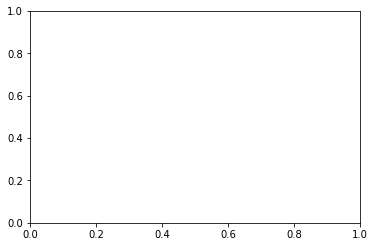

In [17]:
regulation_network.initial_states = np.array(regulation_network.initial_states)
for ix in range(len(regulation_network.initial_states)):
    regulation_network.initial_states[ix] = np.array(regulation_network.initial_states[ix])
regulation_network.plot_concentrations(analysis, 0)

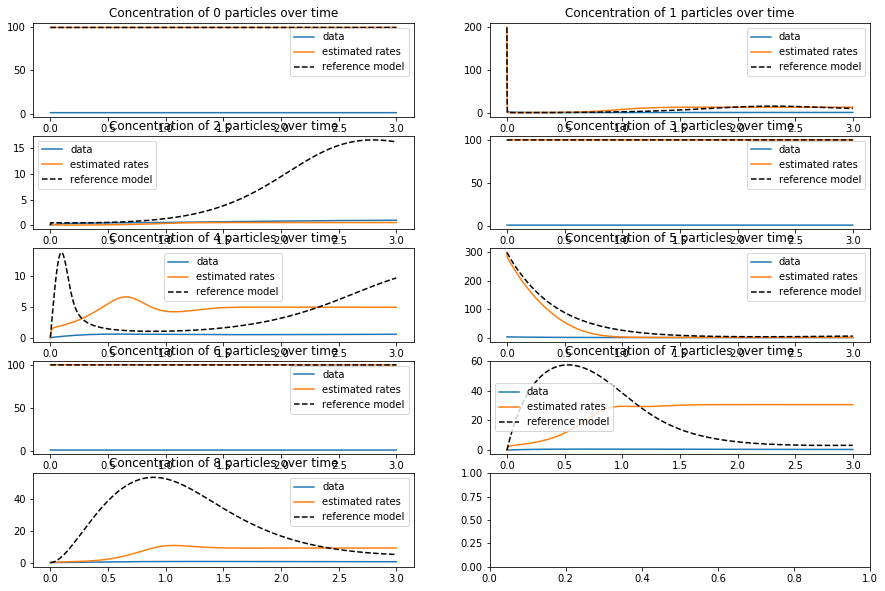

In [18]:
# result = analysis.solve(0, 0., 1., tol=1e-15, recompute=True)
analysis.plot_results(0, result)

In [ ]:
cv = cross_validation.get_cross_validation_object(regulation_network)
cv.n_splits = 15
cv.njobs = 7
cv.splitter = 'kfold'

In [7]:
alphas = np.logspace(-9, -3, num=8*8)
l1_ratios = np.array([1.]) # np.linspace(0, 1, num=5)
result = cv.cross_validate(alphas, l1_ratios, realizations=1)

validating across grid with 64 alphas, 1 lambdas, 1 cutoffs with 1 realizations


HBox(children=(HBox(children=(Label(value='validation 0'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, max=64), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='flex', width='100%'))

train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj

train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj

train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (623, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj

train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj.counts.shape (622, 9)
train_traj

| splitter | split | noise | splits | alphas | file |
| -------- | ----- | ----- | ------ | ------ | ---- |
| shuffle  | 90 : 10 | 1e-10 | 3 | 1e-6 to 1e-2, num=150 | case_2_cross_validation_prelim_results.pickle |
| shuffle  | 70 : 30 | 1e-10 | 20 | 1e-7 to 1e-2, num=200 | case_2_cross_validation_prelim_results_2.pickle |
| shuffle  | 70 : 30 | 1e-10 | 100 | 1e-9 to 1e-4, num=50 | case_2_cross_validation_prelim_results_3.pickle |
| shuffle  | 70 : 30 | 0 | 100 | 1e-6 to 1e-4, num=16 | case_2_cross_validation_prelim_results_4.pickle |
| shuffle  | 50 : 50 | 0 | 30 | 1e-9 to 1e-3, num=128 | case_2_cross_validation_prelim_results_5_50_50.pickle | 
| shuffle  | 50 : 50 | 1e-8 | 15 | 1e-9 to 1e-3, num=64 | case_2_cross_validation_50_50_noise_1e-8.pickle |
| kfold    | - | 0 | 15 | 1e-9 to 1e-3, num=64 | case_2_cv_kfold_15_splits.pickle |

In [8]:
with open('case_2_cv_kfold_15_splits.pickle', 'wb') as f:
    pickle.dump(result, f)

In [9]:
if False:
    noises = np.logspace(-10, -5, 20)
    for noise in noises:
        dt = 4.5e-3
        regulation_network = get_regulation_network(dt, noise)[0]
        cv = cross_validation.get_cross_validation_object(regulation_network)
        cv.n_splits = 3
        fname = 'case_2_cv_noise_{}.pickle'.format(noise)
        if os.path.exists(fname) and os.path.isfile(fname):
            print("skipping noise {}".format(noise))
            continue
        alphas = np.logspace(-6, -2, num=30)
        l1_ratios = np.linspace(0, 1, num=5)
        result = cv.cross_validate(alphas, l1_ratios, realizations=1)
        with open(fname, 'wb') as f:
            pickle.dump(result, f)

In [10]:
with open('case_2_cv_kfold_15_splits.pickle', 'rb') as f:
    result = pickle.load(f)

In [11]:
result_l11 = [r for r in result if r['l1_ratio'] == 1.]

In [58]:
xs = []
ys = []
ys1 = []
ys2 = []
yerr = []
alphas = sorted([r['alpha'] for r in result_l11])
for alpha in alphas:
    for r in result_l11:
        if r['alpha'] == alpha:
            xs.append(alpha)
            ys.append(r['score'][3]) # np.mean(r['score'])
            yerr.append(np.std(r['score']))
            ys1.append(r['score'][1])
            ys2.append(r['score'][2])

In [59]:
ys = np.asarray(ys)
yerr = np.asarray(yerr)
ys1 = np.asarray(ys1)
ys2 = np.asarray(ys2)

In [60]:
xs[np.argmax(ys)]

2.6826957952797274e-06

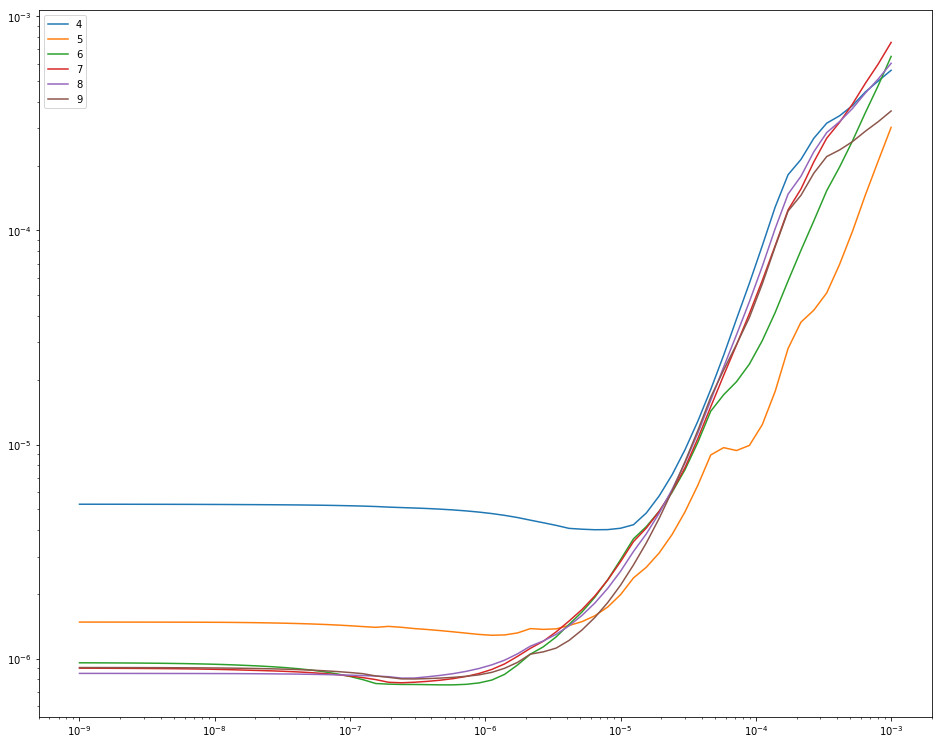

In [66]:
xxs = []
yys = [[] for _ in range(15)]
alphas = sorted([r['alpha'] for r in result_l11])
for alpha in alphas:
    for r in result_l11:
        if r['alpha'] == alpha:
            xxs.append(alpha)
            for ix, score in enumerate(r['score']):
                yys[ix].append(score)
for i in range(4, 10):
    plt.plot(xxs, -np.array(yys[i]), label='{}'.format(i))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

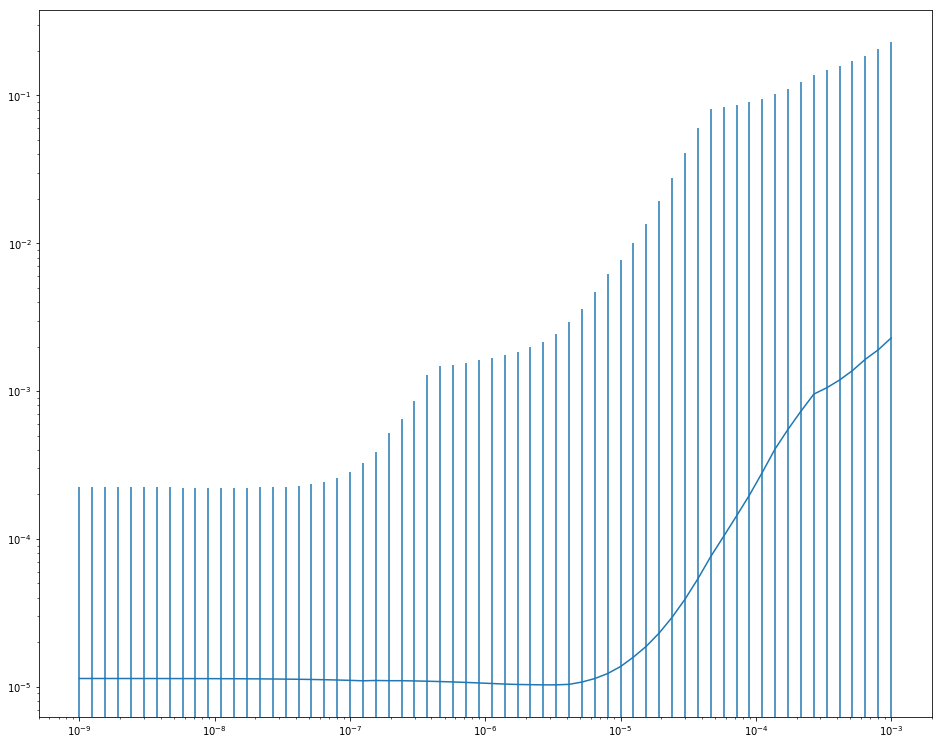

In [61]:
plt.errorbar(xs, -ys, yerr=yerr / np.sqrt(15))
plt.xscale('log')
plt.yscale('log')

In [16]:
regulation_network, analysis = get_regulation_network(dt, noise)

obtaining regulation network with dt = 0.0045 and noise variance 0


In [17]:
for i in range(len(regulation_network.initial_states)):
    analysis.generate_or_load_traj_lma(i, regulation_network.target_time,
                                       noise_variance=regulation_network.noise_variance,
                                       realizations=1)
regulation_network.compute_gradient_derivatives(analysis, persist=False)

In [18]:
rates = analysis.solve(0, xs[np.argmax(ys)], 1., tol=1e-15, persist=False)

optimization problem did exit successfully (alpha=1.389495494373136e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
417 / 30000 iterations


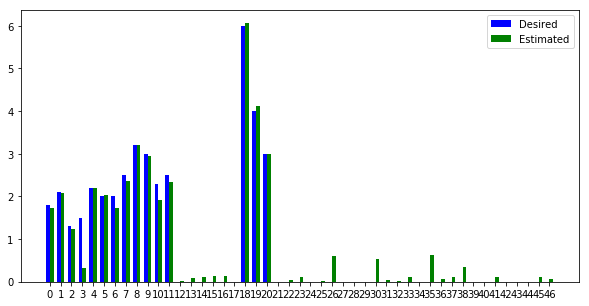

In [19]:
ana.plot_rates_bar(regulation_network.desired_rates, rates)

In [20]:
lsq = analysis.least_squares(0, tol=1e-16, persist=False)

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
422 / 30000 iterations


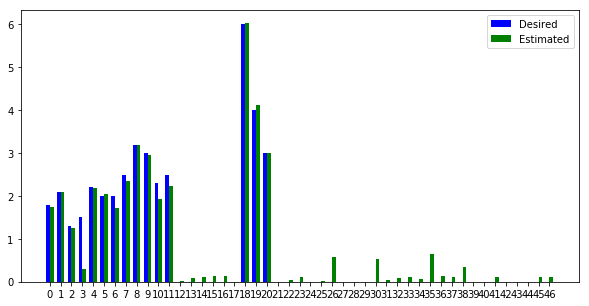

In [21]:
ana.plot_rates_bar(regulation_network.desired_rates, lsq)

optimization problem did exit successfully (alpha=2e-09, lambda=1.0)!
status 0: Optimization terminated successfully.
429 / 30000 iterations


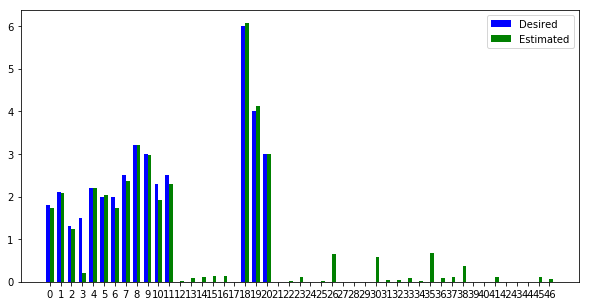

In [23]:
rates2 = analysis.solve(0, 2e-9, 1., tol=1e-15, persist=False)
ana.plot_rates_bar(regulation_network.desired_rates, rates2)